## Pseudo random number generator
We will make an implementation of CAPRNG

In [1]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy as np
from pycuda.compiler import SourceModule

In [2]:
def intToBinArray(val,size=6,dtype=np.bool_):
    li = list(bin(val)[2:])
    li2 = [0]*(size-len(li))
    li2.extend(li)
   
    return np.array(li2).astype(dtype)
    
def intToBinArray_vec(val_array,size=6,dtype=np.bool_):
    val_array2 = np.asarray(val_array)
    result = np.zeros((val_array2.shape[0],val_array2.shape[1],size),dtype=dtype)
    for i in range(val_array2.shape[0]):
        for j in range(val_array2.shape[1]):
            result[i,j,:] = intToBinArray(val_array2[i,j],size=size,dtype=dtype) 
    return result
            
ruleInt = np.array(
       [[ 5, 43, 27,  6, 13, 57, 57, 38],
       [ 59, 21, 61, 10, 32, 25,  0, 37],
       [ 14, 46, 37, 29, 25, 31, 52, 52],
       [ 34, 61, 44, 43,  4, 63, 46,  2],
       [  6,  2,  3, 51, 59, 54, 42, 12],
       [ 47, 61, 63, 36, 33, 24, 45,  5],
       [ 54, 53, 37,  7, 59, 15, 60, 36],
       [ 55, 28, 25, 19, 44, 22, 49, 39]]).astype(np.int32)
ruleBool = intToBinArray_vec(ruleInt)

In [3]:
mod = SourceModule("""
__global__ void prng(bool *dest, bool *a,bool *XCNWSE)
{

        unsigned int x =  blockIdx.x*blockDim.x + threadIdx.x;
        unsigned int y =  blockIdx.y*blockDim.y + threadIdx.y;
        unsigned int nbRow = blockDim.y*gridDim.y;
        unsigned int nbCol = blockDim.x*gridDim.x;
        const unsigned int i = x + y*nbCol;
        
        /*The rule index is the same for every block*/
        const unsigned int ruleIndex = threadIdx.x + threadIdx.y * blockDim.x;
        
        
        if(x >0 && x < nbCol-1 && y > 0 && y < nbRow -1 ){
            dest[i] =                     
                    (XCNWSE[ruleIndex+0]                       )!=
                    (XCNWSE[ruleIndex+1] & a[i]                )!= 
                    (XCNWSE[ruleIndex+2] & a[x   +(y-1)*nbCol] )!=
                    (XCNWSE[ruleIndex+3] & a[x-1 +( y )*nbCol] )!=
                    (XCNWSE[ruleIndex+4] & a[x   +(y+1)*nbCol] )!=
                    (XCNWSE[ruleIndex+5] & a[x+1 +( y )*nbCol] );
        }else{
            dest[i] = 0;
        }

}
""")

prng = mod.get_function("prng")



In [4]:
def makeBorder(array):
    newArray = np.zeros((array.shape[0]+2,array.shape[1]+2),dtype=array.dtype)
    newArray[1:-1,1:-1] = array
    return newArray

In [5]:
shape = (1000,1000) 

X = np.zeros(shape).astype(np.bool_)

In [6]:
def iterate(array):

    blockSizeX = 8
    blockSizeY = 8
    #array = np.random.randint(0,2,shape).astype(np.bool_)


    nBlocksX = int(shape[1]//blockSizeX + (0 if shape[1]%blockSizeX == 0 else 1))
    nBlocksY = int(shape[0]//blockSizeY + (0 if shape[0]%blockSizeY == 0 else 1))

   
    Y = np.zeros_like(X)



    prng(
            drv.Out(Y), drv.In(array),drv.In(ruleBool),
            block=(blockSizeX,blockSizeY,1), grid=(nBlocksX,nBlocksY)
    )
    return Y


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0)
def plotArray(array):
    X = np.copy(array)
    plt.imshow(X,cmap='gray_r',interpolation='none')
    plt.clim(0,1)
    
def plotIterations(gof,nbIteration=1):
    for i in range(nbIteration):
        if i != 0:
            uut.run()
            
        plt.subplot(100 + nbIteration*10+i+1)
        plotArray(uut.array)
        plt.xticks([])
        plt.yticks([])

100 loops, best of 3: 3.62 ms per loop


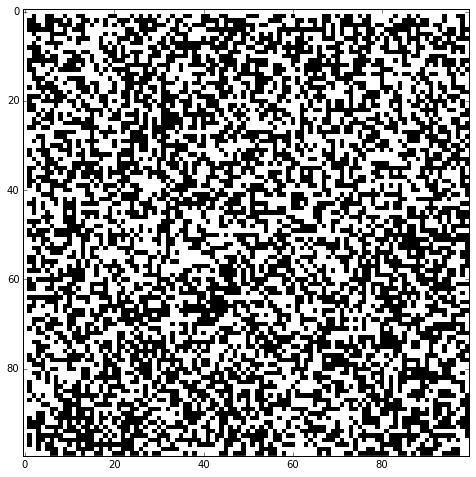

In [8]:
%timeit iterate(X)
Y = iterate(X)
for i in range(200):
    Y=iterate(Y)

plotArray(Y[0:100,0:100])

In [10]:
%timeit Y=np.random.randint(0,2,(1000,1000))

100 loops, best of 3: 12 ms per loop


Once again the performence is not amazing. We won a factor 3 of speed. But the scalability is much better.

In [11]:
from pycuda import curandom
%timeit curandom.rand((1000,1000))

10 loops, best of 3: 187 ms per loop


### Optimization


There is a nice way to optimize the execution by taking advantage of the fact that the cellular automata is infact optimized for 8x8 wrapped grid. This means that wa can use shared memory for double buffering the generation. But it is not usefull as we have to use the data at some point.

### Fixed precision stochastic bitstream generation
We can use this CAPRNG to generate bit streams of fixed precision.
The idea is to use postulate that our random numbers are encoded on $n$ bits with fixed point precision.
We can then compare $n$ cells of our CAPRNG with this number to get a binary result.

In [9]:
mod = SourceModule("""
/**
dest: Nx1 array with caprng < proba result
caprng: Ax1 array with prng booleans
proba: fix point integer version of the proba of precision p
precision: precision ofthe proba
consequently 
**/
__global__ void fp_prng(bool *dest, bool *caprng,unsigned int proba,unsigned int precision)
{
        const unsigned int x =  blockIdx.x*blockDim.x + threadIdx.x;
        const unsigned int y =  blockIdx.y*blockDim.y + threadIdx.y;
        const unsigned int nbCol = blockDim.x*gridDim.x;
        const unsigned int thid = x + y*nbCol;

           
        /**Transform caprng into integer randInt**/
        unsigned int randInt = 0;
        for(unsigned int i = 0 ; i < precision ; ++i){
            randInt |= caprng[thid * precision + i] << i;
        }
        /**Compare it with proba**/
        dest[thid] = randInt < proba;
}
""")


fpprng = mod.get_function("fp_prng")

In [10]:
def floatToFp(val,precision=8):
    valInt = int(val * ((1 << precision)))
    return valInt
floatToFp(0,precision=1)

0

In [11]:
def getFpPrng(proba,precision=8):
    proba = floatToFp(proba,precision)
    

    shapeFpPrng = (1000,1000)
    fpPrng = np.zeros(shapeFpPrng,dtype=np.bool_)

    #how many prng we need
    shapeCaPrng = (shapeFpPrng[0]*precision,shapeFpPrng[1]*precision)

    caPrngIn = np.random.randint(0,2,shapeCaPrng).astype(np.bool_)
    caPrngOut = np.zeros_like(caPrngIn)

    #Topology of caprgng execution
    blockSizeX = 8
    blockSizeY = 8
    nBlocksX = int(shapeCaPrng[1]//blockSizeX + (0 if shapeCaPrng[1]%blockSizeX == 0 else 1))
    nBlocksY = int(shapeCaPrng[0]//blockSizeY + (0 if shapeCaPrng[0]%blockSizeY == 0 else 1))
    prng(
                drv.Out(caPrngOut), drv.In(caPrngIn),drv.In(ruleBool),
                block=(blockSizeX,blockSizeY,1), grid=(nBlocksX,nBlocksY)
        )

    #Topology of fpPrgng execution
    blockSizeX = 32
    blockSizeY = 32
    nBlocksX = int(shapeFpPrng[1]//blockSizeX + (0 if shapeFpPrng[1]%blockSizeX == 0 else 1))
    nBlocksY = int(shapeFpPrng[0]//blockSizeY + (0 if shapeFpPrng[0]%blockSizeY == 0 else 1))
    #print(proba,precision)
    fpprng(
                drv.Out(fpPrng), drv.In(caPrngOut),np.uint32(proba),np.uint32(precision),
                block=(blockSizeX,blockSizeY,1), grid=(nBlocksX,nBlocksY)
        )
    return fpPrng

Let's test it:
1. Probability:
    1. With probability = 0, the result should be an array of zeros
    2. With probability = 1, the result should be an array of one
    3. With probability = 0.5, it should be halph halph
2. Precision:
    1. With precision = 1, and probability = 0.49 the result should be 0
    2. With precision = 1, and probability = 0.51 the result should be 1
etc.



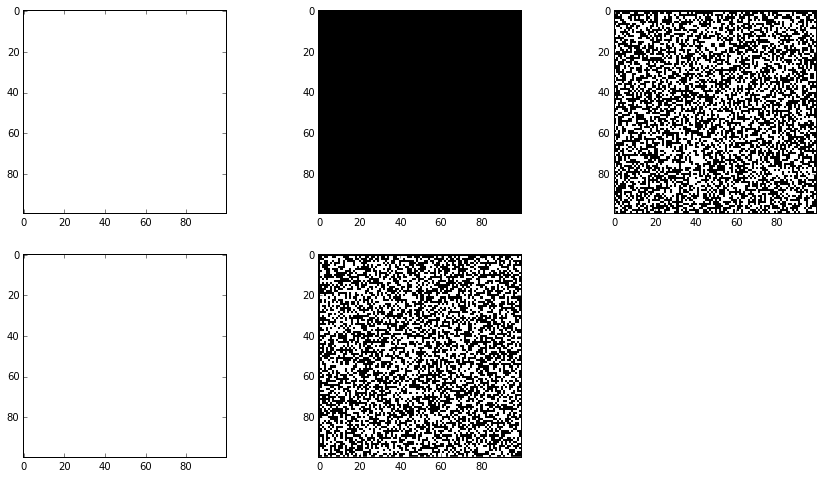

In [12]:

Y = getFpPrng(0)
plt.subplot(231)
plotArray(Y[0:100,0:100])

Y = getFpPrng(1)
plt.subplot(232)
plotArray(Y[0:100,0:100])

Y = getFpPrng(0.5)
plt.subplot(233)
plotArray(Y[0:100,0:100])

Y = getFpPrng(0.49,precision=1)
plt.subplot(234)
plotArray(Y[0:100,0:100])

Y = getFpPrng(0.99,precision=1)
plt.subplot(235)
plotArray(Y[0:100,0:100])

Those tests where a good occasion to correct mistakes (in floatToFp) but also in plotArray demonsrating the usefulness of function unit testing that I should have done for every function. It also show an error for the last testCase: we see the same thing as in the 3rd.
It is due to our function floatToFp which allows 3 values for a precision 1. It is a desirable behaviour so be it.

####What about the speed?

In [13]:
%timeit getFpPrng(0.5)

1 loops, best of 3: 1.18 s per loop


In [137]:
def test(prob=0.5):
    return curandom.rand((1000,1000)) < prob


In [138]:
%timeit test(0.5)

The slowest run took 23.16 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 188 ms per loop


In [15]:
def test2(prob=0.5):
    return (np.random.random((1000,1000)) < prob)

%timeit test2()


100 loops, best of 3: 16.4 ms per loop
